In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from evaluation import *
from model_utils import *
from utils import *

In [2]:
# Load previously run evaluations.
df = pd.read_pickle('data/eval_envs.pkl')
label = Labeler()
df['env_id'] = df.env.apply(label)

In [3]:
def eval_envs(df):
    util = df.groupby('agent env_id'.split()).util.mean()
    std = df.groupby('agent env_id'.split()).util.std()
    over_none = util['BO'] - util['none']
    over_full = util['BO'] - util['full-observation']
    edf = pd.DataFrame({
        'BO': util['BO'],
        'BO - full': over_full,
        'BO - none': over_none,
    })
    bo_worse = (edf[['BO - full', 'BO - none']] < 0).sum(1)
    unusual = abs(((edf - edf.mean(0)) / edf.std(0))).sum(1)
    edf['loss'] = bo_worse * 1e9 + unusual
    return edf

edf = df.groupby('cost').apply(eval_envs)

In [4]:
# Choose envs with lowest cost.
n_env = 10
train = edf.loss.groupby('cost').apply(
    lambda x: list(x.reset_index(0, True).sort_values().index)[:n_env]
)

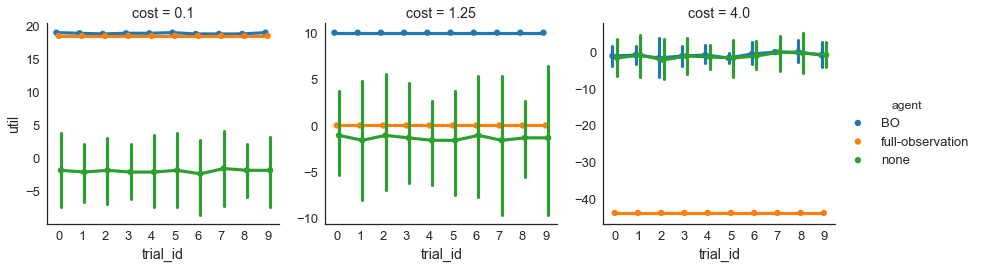

In [5]:
all_train = list(concat(train))
cdf = df.query('env_id == @all_train').copy()
trial_labs = {c: Labeler() for c in train.index}
cdf['trial_id'] = cdf.apply(lambda x: trial_labs[x.cost](x.env_id), axis=1)

sns.factorplot('trial_id', 'util', hue='agent', col='cost',
               sharex=False, sharey=False, dodge=.2, markers='.', data=cdf)

In [12]:
n_test = 6
test = edf.reset_index().query('env_id != @all_train').groupby('cost').apply(
    lambda x: list(x.env_id.sample(n_test))
)

In [74]:
envs = pd.concat([train, test], keys=['train', 'test'], names=['kind']
).unstack().T.stack().apply(lmap(label.unlabel))
envs.to_pickle('data/experiment/envs.pkl')

# Write experiment files

In [64]:
def env_data(env):
    return {
        'trial_id': label(env),
        'objectQs': {str(move): env.true_Q(move) for move in env.tree[0]},
        'stateRewards': list(env.ground_truth),
    }

In [204]:
def to_dict(df, levels):
    if levels:
        return {k: to_dict(v.drop(levels[0], 1), levels[1:]) 
                for k, v in df.groupby(levels[0])}
    else:
        x = df.to_dict(orient='records')
        return x if len(x) > 1 else x[0]
    

In [207]:
data = to_dict(envs.apply(lmap(env_data)).reset_index(), ['cost', 'kind'])
for cost, d in data.items():
    fn = f'data/experiment/rewards_{cost:.2f}.json'
    with open(fn, 'w+') as f:
        json.dump(d, f, indent=2)

In [202]:
from model_utils import read_bo_policy

def optimal_trace(cost):
    agent = Agent()
    agent.register(read_bo_policy(cost))
    envs = make_envs(cost, n=16, ground_truth=1)
    for env in envs:
        agent.register(env)
        trace = agent.run_episode()

        clicks = [{'is_click': 1, 'state': a} for a in trace['actions']]
        moves = [{'is_click': 0, 'state': m} for m in env.best_path()]
        yield clicks + moves

for cost in [0.25, 1.0, 4.0]:
    with open(f'../experiments/exp1/static/json/optimal_policy_{cost:.2f}', 'w+') as f:
        json.dump(list(optimal_trace(cost)), f)

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/exp1/static/json/optimal_policy_0.25'